In [1]:
import torch
import torch.nn as nn
import direct_conv2d  # 确保已经导入direct_conv2d模块

import time
import logging

inp = torch.rand((16,256,56,56)).int()
x = torch.rand((256,256,3,3)).int()
OUT = direct_conv2d.direct_conv2d(inp, x,3,3,1,1,1,0)
# 如果包中有描述信息的属性（这不是标准，可能不存在）
# print(direct_conv2d.__description__)  # 这行可能不会工作，因为__description__不是一个标准属性

Preprocess time: 0.00011837s
direct_conv2d computation time: 1.20312s


In [27]:
import torch
import direct_conv2d
import torch
import torch.nn as nn
import direct_conv2d  # 确保已经导入direct_conv2d模块

import time
import logging
import numpy as np
import torch.nn.quantized

class MeasureExecutionTime:
    def __init__(self, measure_name = "Execution", type='auto', log_to_file=False, log_file='./execution_time.log'):
        self.log_to_file = log_to_file
        self.log_file = log_file
        self.start_time = None
        self.measure_name = measure_name
        self.type=type
        self.type_convert = {"auto":0,"s":1,"ms":1000,"us":1000000,"ns":1000000000}
        if self.type not in self.type_convert.keys():
            raise ValueError(f"Invalid type {self.type}, only support {self.type_convert.keys()}")

    def __enter__(self):
        self.start_time = time.time()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        end_time = time.time()
        execution_time = end_time - self.start_time
        type = self.type
        if type == "auto":
            # 自动选择时间单位
            if execution_time > 1:
                type = "s"
            elif execution_time > 0.001:
                type = "ms"
            elif execution_time > 0.000001:
                type = "us"
            else:
                type = "ns"
        display_time = execution_time*self.type_convert[type]
        print(f"{self.measure_name} time: {display_time:.4f} {type}")
        if self.log_to_file:
            logging.basicConfig(filename=self.log_file, level=logging.INFO)
            logging.info(f"Execution time: {display_time:.4f} {type}")


def direct_conv2d_func(inp, weight, W_bits, A_bits, MT):
    return direct_conv2d.direct_conv2d(inp, weight, W_bits, A_bits, MT)

class DirectConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 kernel_size, W_bits, A_bits, 
                 MT=True, padding=0, 
                 stride=1, dilation=1,
                 prepare_func=lambda x: x.int(),
                 post_func = lambda x: x,
                 measure_time=False):
        super(DirectConv2d, self).__init__()
        self.prepare_func = prepare_func
        self.post_func = post_func
        self.measure_time = measure_time
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.W_bits = W_bits
        self.A_bits = A_bits
        self.MT = MT
        self.padding = padding
        self.stride = stride
        self.dilation = dilation
        max_w = 2**(W_bits) - 1
        max_a = 2**(A_bits) - 1
        regA = 2
        TN =2
        if (W_bits+A_bits)<3:
            TN = 4
        self.align_num = regA*self.kernel_size*TN
        self.weight = torch.randint(0, max_w, 
                               (self.out_channels, 
                                self.in_channels, 
                                self.kernel_size,
                                self.kernel_size)).int()
        
        # 初始化权重，这里假设权重是正方形的
        # 注意：权重的数据类型应该与期望的整型匹配
        # self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size).to(torch.int32))
        # self.weight = torch.randn(out_channels, in_channels, kernel_size, kernel_size).int()
    def set_quant_bits(self, W_bits,A_bits):
        self.W_bits = W_bits
        self.A_bits = A_bits
        max_w = 2**(W_bits) - 1
        max_a = 2**(A_bits) - 1
        self.weight = torch.randint(0, max_w, 
                               (self.out_channels, 
                                self.in_channels, 
                                self.kernel_size,
                                self.kernel_size)).int()
        regA = 2
        TN =2
        if (W_bits+A_bits)<3:
            TN = 4
        self.align_num = self.kernel_size*TN

    def evaluate_perf(self,output_shape,eval_time):
        self.flops = np.prod(output_shape)*np.prod(self.weight.shape)*2/self.in_channels
        perf = self.flops/eval_time
        # auto set 单位
        if perf>1e12:
            perf = perf/1e12
            unit = "TFLOPS"
        elif perf>1e9:
            perf = perf/1e9
            unit = "GFLOPS"
        elif perf>1e6:
            perf = perf/1e6
            unit = "MFLOPS"
        elif perf>1e3:
            perf = perf/1e3
            unit = "KFLOPS"
        return f"{perf:.2f}{unit}"

    def forward(self,inp):
        if self.measure_time:
            return self.measure_forward(inp)
        else:
            return self.direct_forward(inp)
    
    def direct_forward(self,inp):
        # 检查inp和weight的数据类型是否为整型
        if not inp.dtype == torch.int32:
            # raise TypeError("inp and weight must be of int32 type")
            inp = self.prepare_func(inp)
        # 检查inp和weight的形状是否匹配，不匹配则出错：
        if not inp.size(1) == self.in_channels:
            raise ValueError(f"input shape {inp.shape} does not match weight shape {self.weight.shape}")
        # 此处还需要对inp做padding用于计算
        W = inp.size(3)
        W = int((W//self.align_num)*self.align_num+((W%self.align_num)>0)*self.align_num) 
        # employ the new W to padding inp (with zero)
        if W!=inp.size(3):
            inp = torch.nn.functional.pad(inp, (0, W-inp.size(3), 0, 0), mode='constant', value=0)
        # 调用direct_conv2d.direct_conv2d函数
        # print(inp.shape,self.weight.shape)
        # start = time.perf_counter()
        # direct_conv2d_func(inp, self.weight, self.W_bits, self.A_bits, self.MT)
        output =  direct_conv2d.direct_conv2d(inp, self.weight, self.W_bits, self.A_bits, self.MT,1,0,0)
        # eclapsed = time.perf_counter()-start
        # print(output.shape,f"time eclapsed: {eclapsed}s")
        # self.full_perf = self.evaluate_perf(output.shape,eclapsed)
        # 如果输出只要中间的一块，需要对output进行裁剪，其从0位置开始，裁剪出和inp一样大的区域
        # output = self.post_func(output[:, :, 1:1+inp.size(2), 1:1+inp.size(2)])
        # print(output.shape)
        # self.cutted_perf = self.evaluate_perf(output.shape,eclapsed)
        return output
    
    def measure_forward(self, inp):
        with MeasureExecutionTime(measure_name="Check inp type and shape"):
            # 检查inp和weight的数据类型是否为整型
            if not inp.dtype == torch.int32:
                # raise TypeError("inp and weight must be of int32 type")
                inp = self.prepare_func(inp)
            # 检查inp和weight的形状是否匹配，不匹配则出错：
            if not inp.size(1) == self.in_channels:
                raise ValueError(f"input shape {inp.shape} does not match weight shape {self.weight.shape}")
        with MeasureExecutionTime(measure_name="Padding inp"):
            # 此处还需要对inp做padding用于计算
            W = inp.size(3)
            W = int((W//self.align_num)*self.align_num+((W%self.align_num)>0)*self.align_num) 
            # employ the new W to padding inp (with zero)
            inp = torch.nn.functional.pad(inp, (0, W-inp.size(3), 0, 0), mode='constant', value=0)
        with MeasureExecutionTime(measure_name="Direct Conv2d Excution"):
            # 调用direct_conv2d.direct_conv2d函数
            output = direct_conv2d_func(inp, self.weight, self.W_bits, self.A_bits, self.MT)
        with MeasureExecutionTime(measure_name="Post process"):
            # 如果输出只要中间的一块，需要对output进行裁剪，其从0位置开始，裁剪出和inp一样大的区域
            output = self.post_func(output[:, :, 1:1+inp.size(2), 1:1+inp.size(2)])
        return output

    @staticmethod
    def from_conv2d(conv2d, W_bits, A_bits, MT=True, measure_time=False):
        # 从一个标准的Conv2d层构造一个DirectConv2d层
        return DirectConv2d(conv2d.in_channels, conv2d.out_channels, 
                            conv2d.kernel_size[0], W_bits, A_bits, MT, 
                            padding=conv2d.padding[0], stride=conv2d.stride[0], 
                            dilation=conv2d.dilation[0], measure_time=measure_time)
    
class PadConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, 
                kernel_size, 
                W_bits=3,A_bits=3,
                stride=1, 
                padding=0, dilation=1, 
                groups=1, bias=False):
        super(PadConv2d, self).__init__()
        self.align_num = 6
        if W_bits+A_bits<3:
            self.align_num = 12
        self.conv = nn.Conv2d(in_channels, out_channels, 
                kernel_size, stride=stride, 
                padding=2, dilation=dilation, 
                groups=groups, bias=bias)
    
    def forward(self, inp):
        # with MeasureExecutionTime(measure_name="Padding inp"):
        # 此处还需要对inp做padding用于计算
        W = inp.size(3)
        W = int((W//self.align_num)*self.align_num+((W%self.align_num)>0)*self.align_num) 
        # employ the new W to padding inp (with zero)
        if W!=inp.size(3):
            inp = torch.nn.functional.pad(inp, (0, W-inp.size(3), 0, 0), mode='constant', value=0)
        output = self.conv(inp)
        return output[:, :, 1:1+inp.size(2), 1:1+inp.size(2)]
    
    @staticmethod
    def from_conv2d(conv2d, W_bits=3, A_bits=3):
        # 从一个标准的Conv2d层构造一个PadConv2d层
        return PadConv2d(conv2d.in_channels, conv2d.out_channels, 
                        conv2d.kernel_size[0], W_bits, A_bits, 
                        padding=2, stride=conv2d.stride[0], 
                        dilation=conv2d.dilation[0])

class Qint8Conv2D(nn.Module):
    def __init__(self, 
                 in_channels, out_channels, 
                 kernel_size, stride=1, 
                 padding=0, dilation=1, 
                 groups=1, bias=None,return_float=False,engine="qnnpack"):
        super(Qint8Conv2D, self).__init__()
        torch.backends.quantized.engine = engine
        # self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv = torch.nn.quantized.functional.conv2d
        # self.conv.weight.data = self.conv.weight.data.int()
        self.quant = lambda x: torch.quantize_per_tensor(x, 1, 0, torch.quint8)
        weight = torch.randn(out_channels, in_channels, kernel_size, kernel_size)
        self.weight = torch.quantize_per_tensor(weight, 1, 0, torch.qint8)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias
        self.return_float = return_float
    
    def forward(self, inp):
        # 检查，如果不是quint8的类型，则转换一下
        if not inp.dtype == torch.quint8:
            inp = self.quant(inp)
        output = self.conv(inp,self.weight,self.bias,
                           padding=self.padding, stride=self.stride,
                           groups=self.groups,dilation=self.dilation,
                           scale=1.,zero_point=0)
        if self.return_float:
            output = torch.dequantize(output)
        return output
    
    @staticmethod
    def from_float_conv2d(conv2d,copy_weight=True):
        # 从一个标准的Conv2d层构造一个Qint8Conv2D层
        qconv = Qint8Conv2D(conv2d.in_channels, conv2d.out_channels, 
                        conv2d.kernel_size[0], conv2d.stride[0], conv2d.padding[0], 
                        conv2d.dilation[0], conv2d.groups, conv2d.bias)
        if copy_weight:
            qconv.weight = torch.quantize_per_tensor(conv2d.weight.data, 1, 0, torch.qint8)
        return qconv

class PadQint8Conv2D(nn.Module):
    def __init__(self, 
                in_channels, out_channels, 
                kernel_size, 
                W_bits=3,A_bits=3,
                stride=1, 
                padding=0, dilation=1, 
                groups=1, bias=None,return_float=False):
        super(PadQint8Conv2D, self).__init__()
        self.conv = Qint8Conv2D(in_channels, out_channels, kernel_size, 
                                stride, padding=2, dilation=dilation, groups=groups, 
                                bias=bias,return_float=return_float)
        self.align_num = 6
        if (W_bits+A_bits)<3:
            self.align_num = 12
    
    def forward(self, inp):
        # 此处还需要对inp做padding用于计算
        W = inp.size(3)
        W = int((W//self.align_num)*self.align_num+((W%self.align_num)>0)*self.align_num) 
        # employ the new W to padding inp (with zero)
        if W!=inp.size(3):
            if inp.dtype == torch.quint8:
                inp = torch.dequantize(inp)
            inp = torch.nn.functional.pad(inp, (0, W-inp.size(3), 0, 0), mode='constant', value=0)
        output = self.conv(inp)
        return output[:, :, 1:1+inp.size(2), 1:1+inp.size(2)]
    
    @staticmethod
    def from_float_conv2d(conv2d,W_bits=3,A_bits=3,copy_weight=True):
        # 从一个标准的Conv2d层构造一个PadQint8Conv2D层
        qconv = PadQint8Conv2D(conv2d.in_channels, conv2d.out_channels, 
                        conv2d.kernel_size[0], W_bits, A_bits,
                        conv2d.stride[0], conv2d.padding[0], 
                        conv2d.dilation[0], conv2d.groups, conv2d.bias)
        if copy_weight:
            qconv.conv.weight = torch.quantize_per_tensor(conv2d.weight.data, 1, 0, torch.qint8)
        return qconv

In [36]:
import torch
import torch.nn as nn
import direct_conv2d  # 确保已经导入direct_conv2d模块
import time
# Test Direct Conv2D perf
N, Ci, H, W, Co, W_bits,A_bits,MT =1,8,12,12,8,3,3,1
inp = torch.randint(0, 2**A_bits -1, (N, Ci, H, W)).float()
weight = torch.randint(0, 2**W_bits -1, (Co, Ci, 3, 3)).float()
fconv = nn.Conv2d(Ci, Co, 3, padding=2)
qconv = Qint8Conv2D(Ci, Co, 3,padding=2)
dconv = DirectConv2d(Ci, Co, 3, W_bits, A_bits, MT, measure_time=False)
fconv.weight.data.copy_(weight)
dconv.weight.data.copy_(weight.int())
# qconv.weight.data.copy_(weight.int())

# padfconv = PadConv2d(Ci, Co, 3, W_bits, A_bits)
# padqconv = PadQint8Conv2D(Ci, Co, 3, W_bits, A_bits)

with MeasureExecutionTime(measure_name="Float Conv2d"):
    output_f = fconv(inp)

with MeasureExecutionTime(measure_name="Qint8 Conv2d"):
    output_q8 = qconv(inp)


with MeasureExecutionTime(measure_name="Direct Conv2d"):
    output_h3 = dconv(inp)

# with MeasureExecutionTime(measure_name="Pad Float Conv2d"):
#     output_pf = padfconv(inp)
    
# with MeasureExecutionTime(measure_name="Pad Qint8 Conv2d"):
#     output_pq8 = padqconv(inp)

# output = conv(inp)
# print(f"Direct Conv2d full perf: {conv.full_perf}, cutted perf: {conv.cutted_perf}")

# weight = torch.randint(0, 2**W_bits -1, (Co, Ci, 3, 3)).int()
# print(inp.shape,weight.shape)
# start = time.perf_counter()
# # output = direct_conv2d_func(inp, weight, W_bits, A_bits, 1, 0, 1, 1)
# output = direct_conv2d.direct_conv2d(inp, weight, W_bits, A_bits, 1)
# eclapsed = time.perf_counter()-start
# print(output.shape,f"time eclapsed: {eclapsed}s")

Float Conv2d time: 9.4674 ms
Qint8 Conv2d time: 7.5815 ms
Direct Conv2d time: 10.1037 ms


In [37]:
output_h3

tensor([[[[4.0000e+01, 1.1000e+02, 2.2200e+02,  ..., 1.8700e+02,
           1.6900e+02, 8.5000e+01],
          [1.3900e+02, 2.6300e+02, 4.4400e+02,  ..., 4.5500e+02,
           3.6900e+02, 2.0700e+02],
          [1.8900e+02, 3.6600e+02, 6.3000e+02,  ..., 6.3500e+02,
           5.7200e+02, 2.5800e+02],
          ...,
          [1.7700e+02, 4.1200e+02, 6.5900e+02,  ..., 6.0000e+02,
           4.7200e+02, 2.5500e+02],
          [1.2900e+02, 3.2100e+02, 4.5400e+02,  ..., 4.2100e+02,
           3.0400e+02, 1.3000e+02],
          [2.9000e+01, 1.4300e+02, 1.9600e+02,  ..., 2.1000e+02,
           1.5500e+02, 9.4000e+01]],

         [[5.2000e+01, 1.4100e+02, 2.2800e+02,  ..., 2.4300e+02,
           1.7500e+02, 6.6000e+01],
          [1.2200e+02, 2.5100e+02, 4.4600e+02,  ..., 4.4500e+02,
           3.6100e+02, 1.4300e+02],
          [2.2100e+02, 4.4300e+02, 6.6300e+02,  ..., 7.4700e+02,
           5.7200e+02, 2.5200e+02],
          ...,
          [1.8300e+02, 4.5500e+02, 6.7500e+02,  ..., 6.7300

In [38]:
output_f

tensor([[[[ 39.9623, 109.9623, 221.9623,  ..., 186.9623, 168.9623,  84.9623],
          [138.9623, 262.9623, 443.9623,  ..., 454.9623, 368.9623, 206.9623],
          [188.9623, 365.9623, 629.9623,  ..., 634.9623, 571.9623, 257.9623],
          ...,
          [176.9623, 411.9623, 658.9623,  ..., 599.9623, 471.9623, 254.9623],
          [128.9623, 320.9623, 453.9623,  ..., 420.9623, 303.9623, 129.9623],
          [ 28.9623, 142.9623, 195.9623,  ..., 209.9623, 154.9623,  93.9623]],

         [[ 52.0126, 141.0126, 228.0126,  ..., 243.0126, 175.0126,  66.0126],
          [122.0126, 251.0126, 446.0125,  ..., 445.0125, 361.0125, 143.0126],
          [221.0126, 443.0125, 663.0126,  ..., 747.0126, 572.0126, 252.0126],
          ...,
          [183.0126, 455.0125, 675.0126,  ..., 673.0126, 517.0126, 205.0126],
          [133.0126, 318.0125, 449.0125,  ..., 506.0125, 312.0125, 135.0126],
          [ 73.0126, 171.0126, 238.0126,  ..., 227.0126, 175.0126,  72.0126]],

         [[ 73.9063, 142.9063,

In [43]:
# import torch
# import torch.nn.functional as F
# import torch.nn as nn
# import direct_conv2d  # 确保已经导入direct_conv2d模块
# import time
# import numpy as np
# # Test Direct Conv2D perf
# N, Ci, H, W, Co, W_bits,A_bits,MT =16,512,6,12,512,5,5,1
# inp = torch.randint(0, 2**A_bits -1, (N, Ci, H, W)).int()
# weight = torch.randint(0, 2**W_bits -1, (Co, Ci, 3, 3)).int()
print(inp.shape,weight.shape)
start = time.perf_counter()
# output = direct_conv2d_func(inp, weight, W_bits, A_bits, 1, 0, 1, 1)
output = direct_conv2d.direct_conv2d(inp, weight, W_bits, A_bits, 1)
# output = F.conv2d(inp.float(), weight.float(),padding=2)
eclapsed = time.perf_counter()-start
print(output.shape,f"time eclapsed: {eclapsed}s GFPLOPS: {np.prod(output.shape)*np.prod(weight.shape)*2/weight.shape[1]/eclapsed/1e9}")

torch.Size([16, 512, 6, 12]) torch.Size([512, 512, 3, 3])
direct_conv2d computation time: 0.0386138s
torch.Size([16, 512, 8, 14]) time eclapsed: 0.16410746285691857s GFPLOPS: 51.52548651228823


In [5]:
# set_model_quant_bits
def set_model_quant_bits(model, W_bits, A_bits):
	for name, module in model.named_children():
		if isinstance(module, DirectConv2d):
			module.set_quant_bits(W_bits, A_bits)
		else:
			set_model_quant_bits(module, W_bits, A_bits)
	return model
# convert the float conv module to DirectConv2d
def convert_to_direct_conv2d(model, W_bits, A_bits, 
							 module_type=None,
							 module_type_name = None, 
							 prepare_func=lambda x: x.int(),
							 post_func=lambda x: x,
							 copy_weight = False,
							 verbose = True):
	
	for name, module in model.named_children():
		# 分别判断module_type 或者module_type_name来确定是否是该类型
		is_this_type = False
		if module_type is not None and isinstance(module, module_type):
			is_this_type = True
		elif module_type_name is not None and type(module).__name__ == module_type_name:
			is_this_type = True
		# print(f"module name: {name}, module type: {type(module).__name__}, is_this_type: {is_this_type}")
		if is_this_type and \
			module.kernel_size[0]==3 and module.padding[0]==1 \
				and module.stride[0]==1 and module.dilation[0]==1: # 必须要kernel size是3，padding=1, group = 1, 的才能用
			if verbose:
				print(f"convert {name} to DirectConv2d")
			direct_conv2d = DirectConv2d(module.in_channels, 
								module.out_channels, 
								module.kernel_size[0], 
								W_bits, A_bits, True, 
								module.padding[0], module.stride[0], 
								module.dilation[0], prepare_func,post_func)
			direct_conv2d.set_quant_bits(W_bits,A_bits)
			if copy_weight:
				direct_conv2d.weight = module.weight
			setattr(model, name, direct_conv2d)
			# setattr(model, name, f"{name}_direct_conv2d")
		else:
			convert_to_direct_conv2d(module, W_bits, A_bits, 
							module_type, module_type_name,
							prepare_func,post_func,copy_weight,verbose)
	return model

def convert_to_pad_conv2d(model, W_bits, A_bits, 
							 module_type=None,
							 module_type_name = None, 
							 copy_weight = False,
							 verbose = True):
	
	for name, module in model.named_children():
		# 分别判断module_type 或者module_type_name来确定是否是该类型
		is_this_type = False
		if module_type is not None and isinstance(module, module_type):
			is_this_type = True
		elif module_type_name is not None and type(module).__name__ == module_type_name:
			is_this_type = True
		# print(f"module name: {name}, module type: {type(module).__name__}, is_this_type: {is_this_type}")
		if is_this_type and \
			module.kernel_size[0]==3 and module.padding[0]==1 \
				and module.stride[0]==1 and module.dilation[0]==1: # 必须要kernel size是3，padding=1, group = 1, 的才能用
			if verbose:
				print(f"convert {name} to PadConv2d")
			pad_conv2d = PadConv2d(module.in_channels, 
								module.out_channels, 
								module.kernel_size[0], 
								W_bits = W_bits, A_bits = A_bits, 
								stride= module.stride[0], 
								dilation=module.dilation[0])
			# direct_conv2d.set_quant_bits(W_bits,A_bits)
			if copy_weight:
				pad_conv2d.weight.data.cpoy_(module.weight.data)
			setattr(model, name, pad_conv2d)
			# setattr(model, name, f"{name}_direct_conv2d")
		else:
			convert_to_pad_conv2d(module, W_bits, A_bits, 
							module_type, module_type_name,
							copy_weight,verbose)
	return model

class FakeFuseModuleBNReLU(nn.Module):
	def __init__(self, module):
		super(FakeFuseModuleBNReLU, self).__init__()
		self.module = module
	
	def forward(self, x):
		return self.module(x)

class FakeFuseModuleBN(nn.Module):
	def __init__(self, module):
		super(FakeFuseModuleBN, self).__init__()
		self.module = module
	
	def forward(self, x):
		return self.module(x)

class FakeFuseModuleReLU(nn.Module):
	def __init__(self, module):
		super(FakeFuseModuleReLU, self).__init__()
		self.module = module
	
	def forward(self, x):
		return self.module(x)

def fake_fuse_module_bn_relu(model,inplace = False):
	if not inplace:
		model = copy.deepcopy(model)
	pre_conv2d=False
	pre_linear=False
	pointer_module = None
	pointer_name = ""
	next = 0
	for name, module in model.named_children():
		if isinstance(module, (nn.Linear, nn.Conv2d,DirectConv2d,PadConv2d)):
			if pre_conv2d or pre_linear:
				if next==1 and pointer_module is not None:
					setattr(model,pointer_name,FakeFuseModuleBN(pointer_module))

			if isinstance(module, nn.Linear):
				pre_linear = True
			else:
				pre_conv2d = True
			pointer_module = module
			pointer_name = name
			next = 0
			
		elif isinstance(module, (nn.BatchNorm2d,)):
			if pre_conv2d or pre_linear:
				setattr(model, name, nn.Identity())
				next+=1
		elif isinstance(module, (nn.ReLU, )):
			if pre_conv2d or pre_linear:
				setattr(model, name, nn.Identity())
				next+=1
				if next==1 and pointer_module is not None:
					setattr(model,pointer_name,FakeFuseModuleReLU(pointer_module))
				elif next==2 and pointer_module is not None:
					setattr(model,pointer_name,FakeFuseModuleBNReLU(pointer_module))
				pre_linear = False
				pre_conv2d = False
				pointer_module = None
				pointer_name = ""
				next = 0
				
		else:
			if pre_conv2d or pre_linear:
				if next==1 and pointer_module is not None:
					setattr(model,pointer_name,FakeFuseModuleBN(pointer_module))
			pre_linear = False
			pre_conv2d = False
			pointer_module = None
			pointer_name = ""
			next = 0
			fake_fuse_module_bn_relu(module,True)

	return model


In [97]:
# test_module = nn.Sequential(PadConv2d(3, 64, 3, padding=1),nn.BatchNorm2d(64), nn.ReLU(),
# 							nn.AvgPool2d(2,2),
# 							PadConv2d(3, 64, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(64), 
# 							nn.AvgPool2d(2,2),
# 							PadConv2d(3, 64, 3, padding=1),nn.BatchNorm2d(64), 
# 							nn.AvgPool2d(2,2),
# 							nn.Linear(24,24),nn.BatchNorm2d(24),nn.ReLU(),
# 							nn.Linear(24,24),nn.ReLU(), 
# 							nn.Linear(24,24),nn.BatchNorm2d(24),
# 							nn.Linear(24,10))
# fake_fused_module = fake_fuse_module_bn_relu(test_module)
# print(fake_fused_module)

Sequential(
  (0): FakeFuseModuleBNReLU(
    (module): PadConv2d(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    )
  )
  (1): Identity()
  (2): Identity()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): FakeFuseModuleReLU(
    (module): PadConv2d(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    )
  )
  (5): Identity()
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): FakeFuseModuleBN(
    (module): PadConv2d(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    )
  )
  (9): Identity()
  (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (11): FakeFuseModuleBNReLU(
    (module): Linear(in_features=24, out_features=24, bias=True)
  )
  (12): Identity()
  (13): Identity()
  (14): FakeFuseModuleReLU(
    (module): Linear(in_features=24, out_features=24, bias=True)
  )
  (15): Iden

In [174]:
# import torch
# import torch.nn as nn
# import torchvision
# import time
# from torchvision.models import vgg
# from tqdm import tqdm
# import copy
# from torch.quantization import QConfig
# import torch.nn.quantized as nnq
# from torch.ao.quantization import (
#   get_default_qconfig_mapping,
#   get_default_qat_qconfig_mapping,
#   QConfigMapping,
# )
# import torch.ao.quantization.quantize_fx as quantize_fx


# # 定义一些工具函数：
# def eager_quantize_vgg(model,shape):
# 	engine_name = 'qnnpack' # 'fbgemm' # 'qnnpack'
# 	# Set the quantization engine to QNNPACK
# 	torch.backends.quantized.engine = engine_name
# 	# qconfig = torch.quantization.get_default_qconfig(engine_name)
# 	qconfig = QConfig(
# 		weight=torch.quantization.default_observer.with_args(dtype=torch.qint8),  # Use quint8 for weights
# 		activation=torch.quantization.default_observer.with_args(dtype=torch.quint8)  # Use quint8 for activations
# 	)

# 	q_model = copy.deepcopy(model)

# 	q_model.eval()
# 	# 指定要融合的模块序列
# 	modules_to_fuse = [['features.0', 'features.1', 'features.2'],
# 					['features.3', 'features.4', 'features.5'],
# 					['features.7', 'features.8', 'features.9'],
# 					['features.10', 'features.11', 'features.12'],
# 					['features.14', 'features.15', 'features.16'],
# 					['features.17', 'features.18', 'features.19'],
# 					["classifier.0","classifier.1"]
# 					]
# 	# 融合模块
# 	# q_model = torch.quantization.fuse_modules(q_model, modules_to_fuse)
# 	# Prepare the model for quantization
# 	q_model.qconfig = qconfig 
# 	# 只量化卷积层
# 	# for n,m in q_model.named_modules():
# 	# 	if isinstance(m,(nn.Conv2d,torch.quantization.QuantStub,torch.quantization.DeQuantStub)):
# 	# 		m.qconfig = qconfig
# 	torch.quantization.prepare(q_model, inplace=True)
# 	# Quantize the model
# 	# run_model_on_data(model, data)
# 	calibra_data = torch.rand(shape)
# 	q_model(calibra_data)
# 	torch.quantization.convert(q_model, inplace=True)
# 	return q_model

# def fx_quantize_vgg(model,shape):
# 	engine_name = 'qnnpack' # 'fbgemm' # 'qnnpack'
# 	model_fp = copy.deepcopy(model)

# 	# post training static quantization
# 	model_to_quantize = copy.deepcopy(model_fp)
# 	# fusion
# 	model_to_quantize.eval()
# 	model_to_quantize = quantize_fx.fuse_fx(model_to_quantize)
# 	qconfig_mapping = get_default_qconfig_mapping(engine_name)
# 	example_inputs = torch.rand(shape)
# 	# prepare
# 	model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, example_inputs)
# 	# calibrate (not shown)
# 	model_prepared(example_inputs)
# 	# quantize
# 	model_quantized = quantize_fx.convert_fx(model_prepared)
# 	return model_quantized

# def test_inference_speed(model,
#                          input_shape,
#                          qunantize_input=False,
#                         test_iters=100,
#                         verbose = True,
#                         title = ""):
#     quant = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8) # torch.quantization.QuantStub()
#     dequant = torch.dequantize
#     ecalps_time = 0
#     batch_size = input_shape[0]
#     model.eval()
#     with torch.no_grad():
#         # for images, labels in testloader:
#         for i in tqdm(range(test_iters)):
#             images = torch.rand(*input_shape)
#             if qunantize_input:
#                 images = quant(images)
#             start_time = time.time()
#             outputs = model(images)
#             m = outputs.mean().item()
#             ecalps_time += time.time()-start_time
#     if verbose:
#           print(f'{title} Inference time: {ecalps_time} seconds, FPS: {batch_size*test_iters/ecalps_time}')
#     return ecalps_time

In [19]:
# # 搜索所有可以融合的模块列表，Conv|Linear+[BN]+ReLU
# import sys, os
# notebook_path = os.getcwd()  # Get the current working directory
# parent_directory = os.path.dirname(notebook_path)  # Get the parent directory
# sys.path.append(parent_directory)
# from models.conv import DirectConv2d,PadConv2d
# def find_fuse_modules(model,parent_name=""):
# 	pre_conv2d=False
# 	pre_linear=False
# 	pointer_module = None
# 	pointer_name = ""
# 	next = 0
# 	modules_to_fuse = []
# 	tmp_modules_to_fuse = []
# 	for name, module in model.named_children():
# 		module_name = f"{parent_name}.{name}" if parent_name!="" else name
# 		if isinstance(module, (nn.Linear, nn.Conv2d, DirectConv2d,PadConv2d)):
# 			if isinstance(module, nn.Linear):
# 				pre_linear = True
# 			else:
# 				pre_conv2d = True
# 			pointer_module = module
# 			pointer_name = name
# 			next = 0
# 			# module_name = f"{parent_name}.{name}" if parent_name!="" else name
# 			tmp_modules_to_fuse.append(module_name)
			
# 		elif isinstance(module, (nn.BatchNorm2d,)):
# 			if pre_conv2d or pre_linear:
# 				next+=1
# 				# module_name = f"{parent_name}.{name}" if parent_name!="" else name
# 				tmp_modules_to_fuse.append(module_name)
# 		elif isinstance(module, (nn.ReLU, )):
# 			if pre_conv2d or pre_linear:
# 				next+=1
# 				# module_name = f"{parent_name}.{name}" if parent_name!="" else name
# 				tmp_modules_to_fuse.append(module_name)
# 				modules_to_fuse.append(tmp_modules_to_fuse)
# 				tmp_modules_to_fuse = []
# 				pre_linear = False
# 				pre_conv2d = False
# 				pointer_module = None
# 				pointer_name = ""
# 				next = 0
				
# 		else:
# 			if pre_conv2d or pre_linear:
# 				modules_to_fuse.append(tmp_modules_to_fuse)
# 				# if next==1 and pointer_module is not None:
# 				# 	setattr(model,pointer_name,FakeFuseModuleBN(pointer_module))
# 			pre_linear = False
# 			pre_conv2d = False
# 			pointer_module = None
# 			pointer_name = ""
# 			next = 0
# 			tmp_modules_to_fuse = []
# 			# module_name = f"{parent_name}.{name}" if parent_name!="" else name
# 			modules_to_fuse += find_fuse_modules(module,module_name)

# 	return modules_to_fuse

In [20]:
# 获取一个VGGmodel
import torch
from torch import nn
class VGG7(nn.Module):
    def __init__(self,base_inchannels = 64):
        super(VGG7, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        C = base_inchannels
        self.features = nn.Sequential(
            nn.Conv2d(3, C, kernel_size=3, padding=1),
            nn.BatchNorm2d(C),
            nn.ReLU(inplace=True),
            nn.Conv2d(C, C, kernel_size=3, padding=1),
            nn.BatchNorm2d(C),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(C, 2*C, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*C),
            nn.ReLU(inplace=True),
            nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*C),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(2*C, 4*C, kernel_size=3, padding=1),
            nn.BatchNorm2d(4*C),
            nn.ReLU(inplace=True),
            nn.Conv2d(4*C, 4*C, kernel_size=3, padding=1),
            nn.BatchNorm2d(4*C),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
        )
        self.classifier = nn.Sequential(
            
            nn.Linear(4*C, 4*C),
            nn.ReLU(True),
            nn.Linear(4*C, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dequant(x)
        x = self.classifier(x)
        # self.quant()
        return x

find_fuse_modules(VGG7(64))

[['features.0', 'features.1', 'features.2'],
 ['features.3', 'features.4', 'features.5'],
 ['features.7', 'features.8', 'features.9'],
 ['features.10', 'features.11', 'features.12'],
 ['features.14', 'features.15', 'features.16'],
 ['features.17', 'features.18', 'features.19'],
 ['classifier.0', 'classifier.1']]

In [16]:
VGG7(64)

VGG7(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [3]:
# 导入ResNet18
# import torchvision.models as models
# resnet18 = models.resnet18()
# import torch
# import sys, os
# notebook_path = os.getcwd()  # Get the current working directory
# parent_directory = os.path.dirname(notebook_path)  # Get the parent directory
# sys.path.append(parent_directory)
# from models.resnet import ResNet18
# resnet18 = ResNet18()
# convert_to_direct_conv2d(fake_fuse_module_bn_relu(resnet18),3,3, module_type=nn.Conv2d)
resnet18(torch.rand(1,3,224,224))

tensor([[ 1.9894e-01,  5.9960e-01, -8.4103e-01, -2.5476e-01,  5.8460e-01,
         -6.2884e-01,  8.4536e-02,  3.9516e-01,  2.2429e-01, -2.0776e-02,
         -1.5880e-01, -8.8674e-01, -2.1590e-03, -5.6504e-01,  6.4214e-01,
         -1.5023e-01,  4.7914e-01, -4.2196e-01,  1.7772e-01,  3.6359e-01,
          1.1824e+00, -6.9299e-01, -6.7443e-02,  3.7610e-01, -6.2179e-01,
          1.4421e-03, -4.5854e-01,  2.5216e-01,  5.1884e-01,  3.2356e-01,
         -3.4776e-01,  3.5834e-01,  4.2120e-01, -7.6882e-01, -9.6645e-02,
          7.5362e-01,  1.0800e+00, -1.0191e-01,  2.7283e-01,  4.8794e-04,
          3.6986e-01, -2.8406e-01, -6.5788e-01, -2.9301e-01, -2.4342e-01,
          8.3793e-03, -3.1138e-01, -7.9395e-01,  6.9127e-01,  4.8942e-01,
          4.8002e-01,  5.2548e-01, -9.6945e-01, -3.6319e-01,  1.1178e+00,
         -1.0660e-01,  1.4564e-01,  4.4611e-01, -8.1166e-01, -3.1801e-01,
          5.5797e-01, -9.4206e-02,  1.3277e+00, -2.9475e-01,  4.5796e-02,
          1.0006e-01, -4.7705e-02,  1.

In [175]:
# module_func = lambda : VGG7(64)
module_func = models.resnet18
model = convert_to_pad_conv2d(fake_fuse_module_bn_relu(module_func()), 3, 3, module_type=nn.Conv2d, verbose=True)
mymodel = convert_to_direct_conv2d(fake_fuse_module_bn_relu(module_func()),3,3,module_type=nn.Conv2d,verbose=True)
shape = (3,224,224)
batch_size = 4
calibra_shape = (1,*shape)
input_shape = (batch_size,*shape)
# eager quantize
eager_quant_model = eager_quantize_vgg(model, calibra_shape)

# fx quantize
# fx_quant_model = fx_quantize_vgg(model, calibra_shape)
# test_inference_speed(model,
# 					 input_shape,
# 					 qunantize_input=False, 
# 					 verbose=True,
# 					 title="Float")
# test_inference_speed(eager_quant_model, 
# 					 input_shape, 
# 					 qunantize_input=True, 
# 					 verbose=True,
# 					 title="Eager Quantized")
# test_inference_speed(fx_quant_model,
# 					 input_shape,
# 					 qunantize_input=False,
# 					 verbose=True,
# 					 title="FX Quantized")

convert module to PadConv2d
convert conv2 to PadConv2d
convert module to PadConv2d
convert conv2 to PadConv2d
convert module to PadConv2d
convert module to PadConv2d
convert conv2 to PadConv2d
convert module to PadConv2d
convert module to PadConv2d
convert conv2 to PadConv2d
convert module to PadConv2d
convert module to PadConv2d
convert conv2 to PadConv2d
convert module to DirectConv2d
convert conv2 to DirectConv2d
convert module to DirectConv2d
convert conv2 to DirectConv2d
convert module to DirectConv2d
convert module to DirectConv2d
convert conv2 to DirectConv2d
convert module to DirectConv2d
convert module to DirectConv2d
convert conv2 to DirectConv2d
convert module to DirectConv2d
convert module to DirectConv2d
convert conv2 to DirectConv2d


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]
Float Inference time: 40.943278074264526 seconds, FPS: 39.07845378422942
100%|██████████| 100/100 [00:22<00:00,  4.51it/s]
Eager Quantized Inference time: 21.75051259994507 seconds, FPS: 73.56148470744735
100%|██████████| 100/100 [00:22<00:00,  4.49it/s]
FX Quantized Inference time: 21.84299397468567 seconds, FPS: 73.25003165107657

In [145]:
# dconv2d_model = copy.deepcopy(model)
# dconv2d_model = convert_to_direct_conv2d(dconv2d_model, 3, 3, 
# 										 module_type_name=type(model.features[0]).__name__,
# 										 prepare_func=lambda x: x.int())
# quant = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8)
# # dconv2d_model.features[17].post_func = quant
# eager_quant_model
model

VGG7(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (features): Sequential(
    (0): FakeFuseModuleBNReLU(
      (module): PadConv2d(
        (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      )
    )
    (1): Identity()
    (2): Identity()
    (3): FakeFuseModuleBNReLU(
      (module): PadConv2d(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      )
    )
    (4): Identity()
    (5): Identity()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): FakeFuseModuleBNReLU(
      (module): PadConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      )
    )
    (8): Identity()
    (9): Identity()
    (10): FakeFuseModuleBNReLU(
      (module): PadConv2d(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      )
    )
    (11): Identity()
    (12): Identity()
    (13): MaxPool2d(kernel_size=2, stride=2, padd

In [171]:
# dconv2d_model(x)
test_inference_speed(model,
					 input_shape,
					 test_iters = 10,
					 qunantize_input=False,
					 verbose=True,
					 title="Float")

100%|██████████| 10/10 [00:16<00:00,  1.70s/it]

Float Inference time: 16.892439126968384 seconds, FPS: 2.367923288007647


16.892439126968384

In [172]:
# dconv2d_model(x)
test_inference_speed(mymodel,
					 input_shape,
					 test_iters = 10,
					 qunantize_input=False,
					 verbose=True,
					 title="Direct Conv2d")

100%|██████████| 10/10 [00:12<00:00,  1.24s/it]

Direct Conv2d Inference time: 12.24937391281128 seconds, FPS: 3.265473018026261


12.24937391281128

In [176]:
# dconv2d_model(x)
test_inference_speed(eager_quant_model,
					 input_shape,
					 test_iters = 10,
					 qunantize_input=True,
					 verbose=True,
					 title="Eager int8")

  0%|          | 0/10 [00:00<?, ?it/s]


NotImplementedError: Could not run 'aten::add.out' with arguments from the 'QuantizedCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::add.out' is only available for these backends: [CPU, Meta, MkldnnCPU, SparseCPU, SparseCsrCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:31357 [kernel]
Meta: registered at /dev/null:228 [kernel]
MkldnnCPU: registered at /pytorch/build/aten/src/ATen/RegisterMkldnnCPU.cpp:515 [kernel]
SparseCPU: registered at /pytorch/build/aten/src/ATen/RegisterSparseCPU.cpp:1387 [kernel]
SparseCsrCPU: registered at /pytorch/build/aten/src/ATen/RegisterSparseCsrCPU.cpp:1135 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at /pytorch/build/aten/src/ATen/RegisterFunctionalization_0.cpp:21977 [kernel]
Named: fallthrough registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:11 [kernel]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: registered at /pytorch/torch/csrc/autograd/generated/ADInplaceOrViewType_0.cpp:4832 [kernel]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradHIP: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradMPS: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradIPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradXPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradHPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradVE: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradLazy: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradMTIA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradMeta: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:17434 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_2.cpp:17346 [kernel]
AutocastCPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:720 [backend fallback]
BatchedNestedTensor: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:158 [backend fallback]


In [178]:
tmp_inputs = torch.rand(*input_shape)
for i, layer in enumerate(mymodel.features):
	start = time.time()
	tmp_inputs = layer(tmp_inputs)
	print(f"layer {i} {tmp_inputs.shape} time: {(time.time()-start)*1000:.2f}ms")

TypeError: 'ResNet' object is not iterable

In [155]:
tmp_inputs = quant(torch.rand(*input_shape))
for i, layer in enumerate(eager_quant_model.features):
	start = time.time()
	tmp_inputs = layer(tmp_inputs)
	print(f"layer {i} {tmp_inputs.shape} time: {(time.time()-start)*1000:.2f}ms")

layer 0 torch.Size([16, 128, 32, 32]) time: 18.08ms
layer 1 torch.Size([16, 128, 32, 32]) time: 0.07ms
layer 2 torch.Size([16, 128, 32, 32]) time: 0.02ms
layer 3 torch.Size([16, 128, 32, 32]) time: 231.99ms
layer 4 torch.Size([16, 128, 32, 32]) time: 0.04ms
layer 5 torch.Size([16, 128, 32, 32]) time: 0.02ms
layer 6 torch.Size([16, 128, 16, 16]) time: 7.54ms
layer 7 torch.Size([16, 256, 16, 16]) time: 146.10ms
layer 8 torch.Size([16, 256, 16, 16]) time: 0.04ms
layer 9 torch.Size([16, 256, 16, 16]) time: 0.02ms
layer 10 torch.Size([16, 256, 16, 16]) time: 295.80ms
layer 11 torch.Size([16, 256, 16, 16]) time: 0.04ms
layer 12 torch.Size([16, 256, 16, 16]) time: 0.02ms
layer 13 torch.Size([16, 256, 8, 8]) time: 7.25ms
layer 14 torch.Size([16, 512, 8, 8]) time: 231.41ms
layer 15 torch.Size([16, 512, 8, 8]) time: 0.04ms
layer 16 torch.Size([16, 512, 8, 8]) time: 0.02ms
layer 17 torch.Size([16, 512, 8, 8]) time: 307.71ms
layer 18 torch.Size([16, 512, 8, 8]) time: 0.04ms
layer 19 torch.Size([16

In [83]:
# tmp_inputs = quant(torch.rand(*input_shape))
tmp_inputs = torch.rand(*input_shape)
for i, layer in enumerate(model.features):
	start = time.time()
	tmp_inputs = layer(tmp_inputs)
	print(f"layer {tmp_inputs.shape} {i} time: {(time.time()-start)*1000:.2f}ms")

layer torch.Size([16, 128, 32, 32]) 0 time: 101.52ms
layer torch.Size([16, 128, 32, 32]) 1 time: 20.16ms
layer torch.Size([16, 128, 32, 32]) 2 time: 11.49ms
layer torch.Size([16, 128, 32, 32]) 3 time: 635.39ms
layer torch.Size([16, 128, 32, 32]) 4 time: 13.08ms
layer torch.Size([16, 128, 32, 32]) 5 time: 15.57ms
layer torch.Size([16, 128, 16, 16]) 6 time: 7.09ms
layer torch.Size([16, 256, 16, 16]) 7 time: 254.70ms
layer torch.Size([16, 256, 16, 16]) 8 time: 6.28ms
layer torch.Size([16, 256, 16, 16]) 9 time: 4.09ms
layer torch.Size([16, 256, 16, 16]) 10 time: 370.96ms
layer torch.Size([16, 256, 16, 16]) 11 time: 5.85ms
layer torch.Size([16, 256, 16, 16]) 12 time: 4.21ms
layer torch.Size([16, 256, 8, 8]) 13 time: 7.13ms
layer torch.Size([16, 512, 8, 8]) 14 time: 176.16ms
layer torch.Size([16, 512, 8, 8]) 15 time: 2.66ms
layer torch.Size([16, 512, 8, 8]) 16 time: 1.41ms
layer torch.Size([16, 512, 8, 8]) 17 time: 419.73ms
layer torch.Size([16, 512, 8, 8]) 18 time: 7.27ms
layer torch.Size([

In [86]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

# model = models.resnet18().eval()  # 使用ResNet18作为示例模型
inputs = torch.randn(16, 3, 32, 32)  # 创建一个示例输入

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        # with record_function("direct_conv2d_func"):  # 显式地标记你的自定义函数
            # eager_quant_model(quant(inputs))
        dconv2d_model(inputs)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

STAGE:2024-06-23 14:49:41 214608:214608 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        79.17%     354.279ms       100.00%     447.510ms     447.510ms             1  
                      aten::copy_         8.00%      35.799ms         8.00%      35.799ms       2.387ms            15  
                        aten::pad         0.03%     116.000us         7.51%      33.630ms       5.605ms             6  
            aten::constant_pad_nd         0.13%     580.000us         7.49%      33.514ms       5.586ms             6  
                 aten::max_pool2d         0.01%      41.000us         6.31%      28.217ms      14.108ms             2  
    aten::max_pool2d_with_indices       

STAGE:2024-06-23 14:49:41 214608:214608 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-23 14:49:41 214608:214608 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [76]:
# ishape = eager_quant_model.features[0](quant(x)).shape
test_inference_speed(model,
					 [16, 3, 32, 32],
					#  test_iters = 10,
					 qunantize_input=False,
					 verbose=True,
					 title="Float")

100%|██████████| 10/10 [00:15<00:00,  1.55s/it]

Float Inference time: 15.419025897979736 seconds, FPS: 10.376790405479756


15.419025897979736

In [78]:
# ishape = eager_quant_model.features[0](quant(x)).shape
test_inference_speed(eager_quant_model.features[0],
					 [16, 3, 32, 32],
					 qunantize_input=True,
					 verbose=True,
					 title="Eager Quantized")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]

Eager Quantized Inference time: 53.04732060432434 seconds, FPS: 30.161749580799192


53.04732060432434

In [108]:
test_inference_speed(dconv2d_model.features[0],
					 [16, 3, 32, 32],
					 qunantize_input=False,
					 verbose=True,
					 title="Direct Quantized")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 44.08it/s]

Direct Quantized Inference time: 2.1228220462799072 seconds, FPS: 753.7136722335651


2.1228220462799072

In [120]:
import time 

W_bits = 3
A_bits = 3
max_w = 2**(W_bits) - 1
max_a = 2**(A_bits) - 1
N = 16
Ci = 1024
H = 7
W = 12
Co = 1024
K = 3
regA = 2
TN =2
if (W_bits+A_bits)<3:
	TN = 4
align_num = regA*K*TN
W = int((W//align_num)*align_num+((W%align_num)>0)*align_num) 
print("W: ", W)
inp = torch.randint(0, max_a, (N, Ci, H, W)).int()
weight = torch.randint(0, max_w, (Co, Ci, K,K)).int()

conv = DirectConv2d(Ci, Co, K, W_bits, A_bits)
# start = time.time()
for i in range(4):
	# output = direct_conv2d.direct_conv2d(inp, weight, W_bits, A_bits,1,1,1,1)
	out = conv(inp)
# escap_time = time.time() - start
# start = time.time()
output = direct_conv2d.direct_conv2d(inp, weight, W_bits, A_bits,1,0,1,1)
# escap_time = time.time() - start
from tqdm import tqdm
ecalps_time = 0
test_iters = 10
for i in tqdm(range(test_iters)):
	inp = torch.randint(0, max_a, (N, Ci, H, W)).int()
	start_time = time.time()
	output = direct_conv2d.direct_conv2d(inp, weight, W_bits, A_bits,1,0,1,1)
	# out = conv(inp)
	ecalps_time += time.time()-start_time

_,_,Ho,Wo = output.shape
print("Time taken: ", ecalps_time)
flops = 2*N*Ci*Ho*Wo*Co*K*K*test_iters
print("FLOPS: ", flops)
print("GFLOPS: ", flops/ecalps_time/1e9)
print("FPS: ", (N*test_iters)/ecalps_time)


W:  12


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

Time taken:  5.200766324996948
FLOPS:  380507258880
GFLOPS:  73.16369071441088
FPS:  30.764696969940076


In [122]:
# output = direct_conv2d.direct_conv2d(inp, weight, W_bits, A_bits,1,1,1,1)
# output.shape
# output_quant.shape
# 2*N*Ci*H* W* Co*K*K*test_iters
# 2*N*Ci*Ho*Wo*Co*K*K*test_iters
# Ho,H,Wo,W

torch.Size([16, 1024, 9, 14])

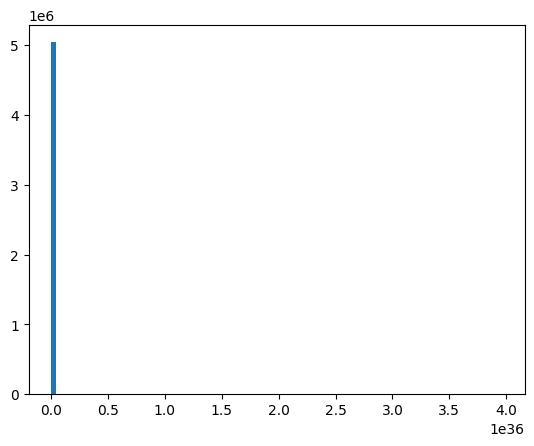

In [33]:
import matplotlib.pyplot as plt
_ = plt.hist(output.numpy().flatten(), bins=100)

In [126]:
from torch.nn.functional import conv2d

inp = torch.randint(0, max_a, (N, Ci, H, W)).float()
weight = torch.randint(0, max_w, (Co, Ci, K,K)).float()

escap_time = 0
for i in tqdm(range(test_iters)):
	start = time.time()
	float_output = conv2d(inp, weight, groups = 1, stride = 1, padding = 2, dilation = 1)
	escap_time += time.time() - start
_,_,Ho,Wo = float_output.shape
print("Time taken: ", escap_time)
flops = 2*N*Ci*Ho*Wo*Co*K*K*test_iters
print("FLOPS: ", flops)
print("GFLOPS: ", flops/escap_time/1e9)
print("FPS: ", (N*test_iters)/escap_time)


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]

Time taken:  18.856735706329346
FLOPS:  380507258880
GFLOPS:  20.17885093188643
FPS:  8.485031687976372


In [125]:
import torch
import time
from torch.nn.quantized.functional import conv2d

# 假设N, Ci, H, W, Co, K, max_a, max_w, scale, zero_point已经定义
inp = torch.randint(0, max_a, (N, Ci, H, W)).float()
weight = torch.randint(0, max_w, (Co, Ci, K, K)).float()
scale = torch.tensor(1.0)  # 实际应用中应通过量化校准过程得到
zero_point = torch.tensor(0)  # 对于输入使用quint8，zero_point通常为0

# 创建量化的输入和权重
inp_quant = torch.quantize_per_tensor(inp, scale=scale, zero_point=zero_point, dtype=torch.quint8)
weight_quant = torch.quantize_per_tensor(weight, scale=scale, zero_point=zero_point, dtype=torch.qint8)

# 执行量化卷积操作
elapsed_time = 0
for i in tqdm(range(test_iters)):
	start = time.time()
	output_quant = conv2d(inp_quant, weight_quant, None, stride=1, padding=2, dilation=1, groups=1, scale=scale, zero_point=zero_point)
	elapsed_time += time.time() - start

_,_,Ho,Wo = output_quant.shape
# 性能测量
print("Time taken: ", elapsed_time)
# 注意：这里的FLOPS计算需要根据实际的输出尺寸进行调整
flops = 2 * N * Co * Ho * Wo * Ci * K * K*test_iters  # 这里假设输出尺寸与输入相同，实际上可能不同
print("FLOPS: ", flops)
print("GFLOPS: ", flops / elapsed_time / 1e9)
print("FPS: ", (N*test_iters)/elapsed_time)

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]

Time taken:  10.207385301589966
FLOPS:  380507258880
GFLOPS:  37.27764237730203
FPS:  15.674925093214362


In [6]:
import torch
import time
from torch.quantization import QuantStub, DeQuantStub
from tqdm import tqdm

# 假设N, Ci, H, W, Co, K, max_a, max_w已经定义
W_bits = A_bits = 4
N = 16
Ci = 64
H = 224
align_num = 12
if W_bits + A_bits < 3:
    align_num = 24
W = H//align_num*align_num+((H%align_num)>0)*align_num
Co = 64
K = 3
# Flops = 2 * N * Co * H * W * Ci * K * K

# 准备输入和权重
# inp = torch.randint(0, max_a, (N, Ci, H, W)).float()
# weight = torch.randint(0, max_w, (Co, Ci, K, K)).float()
# inp = torch.rand(N, Ci, H, W)
weight = torch.rand(Co, Ci, K, K)

# 量化准备
# quant = QuantStub()
# dequant = DeQuantStub()
quant = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8) # torch.quantization.QuantStub()
dequant = torch.dequantize

# 量化输入和权重
# inp_quant = quant(inp)
# weight_quant = quant(weight)
class WrappedConv2d(torch.nn.Module):
    def __init__(self, conv_layer, W_bits=3, A_bits=3,quantize = False):
        super().__init__()
        self.align_num = 12
        if W_bits+A_bits<3:
            self.align_num = 24
        self.conv = conv_layer
        self.quantize = quantize
        self.quant = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8) 
        self.dequant = lambda x: x.dequantize()
    
    def forward(self, inp):
        # with MeasureExecutionTime(measure_name="Padding inp"):
        # 此处还需要对inp做padding用于计算
        padding = 2
        W = inp.size(3)
        W = int((W//self.align_num)*self.align_num+((W%self.align_num)>0)*self.align_num) + padding
        # employ the new W to padding inp (with zero)
        if W!=inp.size(3):
            if self.quantize:
                inp = self.dequant(inp)
            inp = torch.nn.functional.pad(inp, (0, W-inp.size(3), 0, 0), mode='constant', value=0)
            if self.quantize:
                inp = self.quant(inp)
        # print("input shape: ",inp.shape)
        output = self.conv(inp)
        # print("output shape: ",output.shape)
        return output[:, :, 1:2+inp.size(2), 1:2+inp.size(2)]
    
# 量化卷积操作
# 注意：这里我们需要一个量化的conv2d函数，但PyTorch不直接提供一个简单的API来量化然后执行conv2d
# 因此，我们使用量化模型的概念来近似这个过程
class QuantizedConv2d(torch.nn.Module):
    def __init__(self):
        super(QuantizedConv2d, self).__init__()
        # self.conv1 = torch.nn.Conv2d(Ci, Co, K, stride=1, padding=2, dilation=1, groups=1)
        # self.conv2 = torch.nn.Conv2d(Ci, Co, K, stride=1, padding=2, dilation=1, groups=1)
        self.conv1 = PadConv2d(Ci,Co,K,W_bits =W_bits,A_bits=A_bits,stride=1, dilation=1, groups=1)
        self.conv2 = PadConv2d(Ci,Co,K,W_bits =W_bits,A_bits=A_bits,stride=1, dilation=1, groups=1)
        # self.quant = QuantStub()
        # self.dequant = DeQuantStub()

    def forward(self, x):
        # x = self.quant(x)
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.dequant(x)
        return x
    
class QuantizedConv2d_2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        src_conv1 = torch.nn.Conv2d(Ci, Co, K, stride=1, padding=1, dilation=1, groups=1)
        src_conv2 = torch.nn.Conv2d(Ci, Co, K, stride=1, padding=1, dilation=1, groups=1)
        self.conv1 = WrappedConv2d(src_conv1,W_bits =W_bits,A_bits=A_bits,quantize=True)
        self.conv2 = WrappedConv2d(src_conv2,W_bits =W_bits,A_bits=A_bits,quantize=True)
        # self.quant = QuantStub()
        # self.dequant = DeQuantStub()

    def forward(self, x):
        # x = self.quant(x)
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.dequant(x)
        return x

class MyQuantizedConv2d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv = torch.nn.Conv2d(Ci, Co, K, stride=1, padding=4, dilation=1, groups=1)
        # self.quant = QuantStub()
        self.conv1 = DirectConv2d(Ci, Co, K, 3, 3, True, 0, 1, 1, measure_time=False)
        self.conv2 = DirectConv2d(Ci, Co, K, 3, 3, True, 0, 1, 1, measure_time=False)
        # self.dequant = DeQuantStub()

    def forward(self, x):
        # x = self.quant(x)
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.dequant(x)
        return x

# 将权重复制到量化模型中
model = QuantizedConv2d()
# model.conv1.weight = torch.nn.Parameter(weight)
# model.conv1.bias = None  # 假设没有偏置

mymodel = MyQuantizedConv2d()

batch_size = 16
test_iters = 10
shape = (batch_size, Ci, H, W)
Ho = H+2
Wo = W+2
Flops = 2 * batch_size * Co * Ho * Wo * Ci * K * K
# Function to test the inference speed
def test_inference_speed(model,input_shape,qunantize_input=False):
    ecalps_time = 0
    with torch.no_grad():
        # for images, labels in testloader:
        for i in tqdm(range(test_iters)):
            images = torch.rand(*input_shape)
            if qunantize_input:
                images = quant(images)
            start_time = time.time()
            outputs = model(images)
            m = outputs.mean().item()
            ecalps_time += time.time()-start_time
    return ecalps_time


In [25]:
fp32_inference_time = test_inference_speed(model,shape,qunantize_input=False)
print(f'FP32 inference time: {fp32_inference_time:.2f} seconds, FPS: {batch_size*test_iters/fp32_inference_time:.2f}, GFLOPS: {Flops*test_iters/fp32_inference_time/1e9:.2f}')

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
my_inference_time = test_inference_speed(mymodel,shape,qunantize_input=False)
print(f'Our inference time: {my_inference_time:.2f} seconds, FPS: {batch_size*test_iters/my_inference_time:.2f}, GFLOPS: {Flops*test_iters/my_inference_time/1e9:.2f}')

100%|██████████| 10/10 [01:08<00:00,  6.85s/it]

Our inference time: 58.83 seconds, FPS: 2.72, GFLOPS: 10.42


In [8]:
import copy
from torch.quantization import QConfig
import torch.nn.quantized as nnq

model_2 = QuantizedConv2d()
# 量化模型准备和转换
engine_name = 'qnnpack' # 'fbgemm' # 'qnnpack'
# Set the quantization engine to QNNPACK
torch.backends.quantized.engine = engine_name
# qconfig = torch.quantization.get_default_qconfig(engine_name)
qconfig = QConfig(
    weight=torch.quantization.default_observer.with_args(dtype=torch.qint8),  # Use quint8 for weights
    activation=torch.quantization.default_observer.with_args(dtype=torch.quint8)  # Use quint8 for activations
)

q_model = copy.deepcopy(model_2)
# Prepare the model for quantization
q_model.qconfig = qconfig 
torch.quantization.prepare(q_model, inplace=True)
# Quantize the model
# run_model_on_data(model, data)
# calibra_data = torch.rand(4,3,32,32)
# q_model(calibra_data)
torch.quantization.convert(q_model, inplace=True)

# start = time.time()
# output_quant = model(inp_quant)
# escap_time = time.time() - start

# 性能测量
# print("Time taken: ", escap_time)
# flops = 2*N*Ci*H*W*Co*K*K
# print("FLOPS: ", flops)
# print("GFLOPS: ", flops/escap_time/1e9)

int8_inference_time = test_inference_speed(q_model,shape,qunantize_input=True)
print(f'EAGER INT8 inference time: {int8_inference_time:.2f} seconds, FPS: {batch_size*test_iters/int8_inference_time:.2f}, GFLOPS: {Flops*test_iters/int8_inference_time/1e9:.2f}')

/data/newhome/gongcheng/.local/lib/python3.9/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
100%|██████████| 10/10 [00:54<00:00,  5.41s/it]

EAGER INT8 inference time: 42.92 seconds, FPS: 3.73, GFLOPS: 14.29


In [35]:
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx
import copy

# fx module for quantization
model_fp = copy.deepcopy(model)

# post training static quantization
model_to_quantize = copy.deepcopy(model_fp)
# fusion
model_to_quantize.eval()
model_to_quantize = quantize_fx.fuse_fx(model_to_quantize)
qconfig_mapping = get_default_qconfig_mapping("onednn")
example_inputs = torch.rand((1,Ci,H,W))
# prepare
model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, example_inputs)
# calibrate (not shown)
# model_prepared(example_inputs)
# quantize
model_quantized = quantize_fx.convert_fx(model_prepared)

fx_int8_inference_time = test_inference_speed(q_model,shape,qunantize_input=True)
print(f'FX int8 inference time: {fx_int8_inference_time} seconds, FPS: {batch_size*test_iters/fx_int8_inference_time}, GFLOPS: {Flops*test_iters/fx_int8_inference_time/1e9:.2f}')

100%|██████████| 10/10 [00:00<00:00, 47.90it/s]

FX int8 inference time: 0.19815945625305176 seconds, FPS: 807.4305563075338, GFLOPS: 2.86
